In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import us
import re

# Read in and Clean Data

### Spending Data

In [2]:
# source: Prof. Fulton
spending = pd.read_excel('data/IIJA FUNDING AS OF MARCH 2023.xlsx', engine = 'openpyxl', names=['area','spending'])

spending.columns = ['state', 'spending']
spending.state = spending.state.str.lower()
spending.loc[spending.state == 'deleware', 'state'] = 'delaware'

display(spending.head(), spending.tail())

,state,spending
0,alabama,3.0000
1,alaska,3.7000
2,american samoa,0.0686
3,arizona,3.5000
4,arkansas,2.8000


,state,spending
52,virginia,4.5
53,washington,4.0
54,west virginia,2.0
55,wisconsin,2.8
56,wyoming,2.3


### Population Data

In [3]:
# Source: Census.gov
population = pd.read_excel(
    'https://www2.census.gov/programs-surveys/popest/tables/2020-2023/state/totals/NST-EST2023-POP.xlsx',
    engine='openpyxl', header=3
)

population.columns = ['state', 'pop_base', 'pop2020', 'pop2021', 'pop2022', 'pop2023']
population.state = population.state.str.replace('.', '', regex=False)
population.state = population.state.str.lower()
population = population.dropna(axis=0, how='any')

display(population.head(7), population.tail())

,state,pop_base,pop2020,pop2021,pop2022,pop2023
0,united states,331464948.0,331526933.0,332048977.0,333271411.0,334914895.0
1,northeast,57614141.0,57430477.0,57243423.0,57026847.0,56983517.0
2,midwest,68987296.0,68969794.0,68850246.0,68783028.0,68909283.0
3,south,126268529.0,126465281.0,127353282.0,128702030.0,130125290.0
4,west,78594982.0,78661381.0,78602026.0,78759506.0,78896805.0
5,alabama,5024294.0,5031864.0,5050380.0,5073903.0,5108468.0
6,alaska,733374.0,732964.0,734923.0,733276.0,733406.0


,state,pop_base,pop2020,pop2021,pop2022,pop2023
52,washington,7705267.0,7724566.0,7741433.0,7784477.0,7812880.0
53,west virginia,1793713.0,1791562.0,1785249.0,1774035.0,1770071.0
54,wisconsin,5893713.0,5896700.0,5879978.0,5890543.0,5910955.0
55,wyoming,576850.0,577664.0,579548.0,581629.0,584057.0
57,puerto rico,3285874.0,3281557.0,3262693.0,3220113.0,3205691.0


### Party Data

In [4]:
# source: https://electionlab.mit.edu/data
election_results = pd.read_csv('data/1976-2020-president.csv')
election_results = election_results.loc[election_results.year == 2020]

idx = election_results.groupby('state')['candidatevotes'].idxmax()
state_by_winner = election_results.loc[idx]
state_by_winner = state_by_winner[['state', 'candidate']]
state_by_winner['party'] = np.where(state_by_winner['candidate'] == 'BIDEN, JOSEPH R. JR', 'dem', 'rep')
state_by_winner['state'] = state_by_winner['state'].str.lower()

display(state_by_winner.head(), state_by_winner.tail())

,state,candidate,party
3741,alabama,"TRUMP, DONALD J.",rep
3745,alaska,"TRUMP, DONALD J.",rep
3752,arizona,"BIDEN, JOSEPH R. JR",dem
3771,arkansas,"TRUMP, DONALD J.",rep
3773,california,"BIDEN, JOSEPH R. JR",dem


,state,candidate,party
4252,virginia,"BIDEN, JOSEPH R. JR",dem
4256,washington,"BIDEN, JOSEPH R. JR",dem
4264,west virginia,"TRUMP, DONALD J.",rep
4267,wisconsin,"BIDEN, JOSEPH R. JR",dem
4281,wyoming,"TRUMP, DONALD J.",rep


In [5]:
# according to https://www.newsweek.com/expanding-map-swing-states-that-will-decide-2024-election-1819263 &
# https://amac.us/newsline/elections/swing-states-2024/
swing_states = [
    'arizona', 'florida', 'georgia', 'indiana', 'iowa', 'michigan',
    'north carolina', 'ohio', 'pennsylvania', 'wisconsin'
]

### GDP Data

In [6]:
# source: Bureau of Economic Analysis
gdp = pd.read_excel('https://www.bea.gov/sites/default/files/2023-12/stgdppi3q23.xlsx', engine='openpyxl', header=3)

gdp = gdp.loc[:, ['Unnamed: 0','2022.1']]
gdp.columns = ['state', 'real_gdp']
gdp = gdp.dropna(axis=0, how='any')
gdp.state = gdp.state.str.strip().str.lower()

display(gdp.head(), gdp.tail())

,state,real_gdp
2,united states,21822037
3,new england,1140308
4,connecticut,276669
5,maine,72414
6,massachusetts,604358


,state,real_gdp
58,hawaii,85211
59,nevada,187226
60,oregon,254708
61,washington,641144
62,overseas activity2,...


### Debt & Infrastructure Spending Data

In [7]:
# Source: Census.gov
finances = pd.read_excel(
    'https://www2.census.gov/programs-surveys/gov-finances/tables/2021/21slsstab1.xlsx', 
    engine='openpyxl', header=10, index_col=1
)

states = []
current_state = None

for col in finances.columns:
    current_state = col.lower() if 'Unnamed' not in col else current_state
    states.append(current_state)

finances.iloc[1,:] = states

finances.columns = states

# finances = finances.loc[:, (finances.iloc[0, :] == 'State & local') & (finances.iloc[2, :] == 'amount1')]
finances = finances.loc[:, finances.iloc[0, :] == ' State']

finances.index = finances.index.str.strip()

finances = pd.DataFrame({
    'state' : finances.T.index, # loc['Debt outstanding'].
    'revenue' : finances.loc['Revenue1'].T,
    'debt' : finances.loc['Debt outstanding'].T,
    'infrastructure' : (
        finances.loc['Expenditure1':].loc['Highways'].T + 
        finances.loc['Expenditure1':].loc['Air transportation (airports)'].T + 
        finances.loc['Expenditure1':].loc['Parking facilities'].T + 
        finances.loc['Expenditure1':].loc['Sea and inland port facilities'].T + 
        finances.loc['Expenditure1':].loc['Utility expenditure'].T
    )
})
finances = finances.reset_index(drop=True)

display(finances.head(), finances.tail())

,state,revenue,debt,infrastructure
0,united states total,3975040333,1208170688,164442737
1,alabama,43769959,9118128,1720709
2,alaska,14186218,5652311,1482688
3,arizona,68592195,8969733,1336701
4,arkansas,42968905,7868953,1589453


,state,revenue,debt,infrastructure
47,virginia,97747751,31041855,5554361
48,washington,102871984,30206602,2450061
49,west virginia,22371082,13368743,1663989
50,wisconsin,65795068,21978336,2185640
51,wyoming,8179668,924246,620168


### Road Miles Data

In [8]:
# source: https://www.fhwa.dot.gov/policyinformation/statistics/2021/hm60.cfm
roads = pd.read_csv('data/hm60.csv')

roads.index = roads.iloc[:,0]
roads.index.name = 'State'
roads.index = roads.index.str.lower()

roads.columns = roads.iloc[0,:] + ' ' + roads.iloc[1,:] + ' ' + roads.iloc[2,:]

roads = roads['TOTAL LANE MILES']
roads = roads.dropna()
roads = roads.iloc[4:]
roads.name = 'road_miles'

roads = pd.to_numeric(roads.str.replace(',', ''))

roads = roads.rename(index={'maine  (3)':'maine'})

print(roads.head(), roads.tail())

State
alaska         35927
arizona       162428
arkansas      204358
california    400218
colorado      186199
Name: road_miles, dtype: int64 State
wisconsin       239518
wyoming          62588
u.s. total     8823515
puerto rico      41587
grand total    8865103
Name: road_miles, dtype: int64


### Land Area Data

In [9]:
# source: https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
land_area = pd.read_csv('data/landArea_census.csv')

land_area = land_area.loc[:, [x for x in land_area.columns if 'Unnamed' not in x and 'Internal' not in x]]
land_area.columns = ['state', 'total_area', 'land_area', 'water_area']

land_area = land_area.dropna(axis=0, how='any')

land_area.state = land_area.state.str.lower()
land_area.state = land_area.state.str.replace('[0-9:]', '', regex=True)

for col in land_area.columns[1:]:
    land_area[col] = pd.to_numeric(land_area[col].str.replace(',', ''))

display(land_area.head(), land_area.tail())

,state,total_area,land_area,water_area
2,total,3805927,3535932,269995
4,united states,3796742,3531905,264837
5,alabama,52420,50645,1775
6,alaska,665384,570641,94743
7,arizona,113990,113594,396


,state,total_area,land_area,water_area
59,island areas,3860,603,3257
60,american samoa,581,76,505
61,guam,571,210,361
62,northern mariana islands,1976,182,1793
63,u.s. virgin islands,733,134,599


# Merge Datasets

In [10]:
display(population.state[~population.state.isin(spending.state)], spending.state[~spending.state.isin(population.state)])

0    united states
1        northeast
2          midwest
3            south
4             west
Name: state, dtype: object

2               american samoa
12                        guam
37    northern mariana islands
48          tribal communities
49           us virgin islands
Name: state, dtype: object

In [11]:
data = pd.merge(population, spending, on='state', how='inner')
data = pd.merge(data, state_by_winner, on='state', how='inner')
data = pd.merge(data, finances, on='state', how='inner') ## FIX TO KEEP PR
data = pd.merge(data, gdp, on='state', how='inner')
data = pd.merge(data, land_area, on='state', how='inner')
data = pd.merge(data, roads, left_on='state', right_index=True, how='inner')

# data = data.drop([x for x in data.columns if 'state' in x], axis=1)

data['spending_per_capita'] = (data['spending'] * 10**9) / data['pop2023']
data['debt_per_capita'] = (data['debt'] * 1000) / data['pop2023']
data['party_alt'] = np.where(data['state'].isin(swing_states), 'swing', data['party'])

mapping = us.states.mapping('name', 'abbr')
mapping = {key.lower(): value for key, value in mapping.items()}

data['area_abbr'] = data['state'].map(mapping)
data.loc[data.area_abbr.isnull(), 'area_abbr'] = 'DC'

print(f'Shape: {data.shape}\n\n')
display(data.head(), data.tail())

Shape: (50, 21)




,state,pop_base,pop2020,pop2021,pop2022,pop2023,spending,candidate,party,revenue,...,infrastructure,real_gdp,total_area,land_area,water_area,road_miles,spending_per_capita,debt_per_capita,party_alt,area_abbr
1,alaska,733374.0,732964.0,734923.0,733276.0,733406.0,3.7,"TRUMP, DONALD J.",rep,14186218,...,1482688,50315,665384,570641,94743,35927,5044.954636,7706.933131,rep,AK
2,arizona,7157902.0,7186683.0,7272487.0,7365684.0,7431344.0,3.5,"BIDEN, JOSEPH R. JR",dem,68592195,...,1336701,403474,113990,113594,396,162428,470.978063,1207.013563,swing,AZ
3,arkansas,3011490.0,3014348.0,3028443.0,3046404.0,3067732.0,2.8,"TRUMP, DONALD J.",rep,42968905,...,1589453,137356,53179,52035,1143,204358,912.726405,2565.071851,rep,AR
4,california,39538212.0,39503200.0,39145060.0,39040616.0,38965193.0,18.4,"BIDEN, JOSEPH R. JR",dem,658433234,...,14331529,3167461,163695,155779,7916,400218,472.216319,3703.657852,dem,CA
5,colorado,5773707.0,5785219.0,5811596.0,5841039.0,5877610.0,3.2,"BIDEN, JOSEPH R. JR",dem,60456263,...,1586688,416114,104094,103642,452,186199,544.438981,3798.909931,dem,CO


,state,pop_base,pop2020,pop2021,pop2022,pop2023,spending,candidate,party,revenue,...,infrastructure,real_gdp,total_area,land_area,water_area,road_miles,spending_per_capita,debt_per_capita,party_alt,area_abbr
46,virginia,8631373.0,8637193.0,8657348.0,8679099.0,8715698.0,4.5,"BIDEN, JOSEPH R. JR",dem,97747751,...,5554361,576964,42775,39490,3285,164769,516.309767,3561.602869,dem,VA
47,washington,7705267.0,7724566.0,7741433.0,7784477.0,7812880.0,4.0,"BIDEN, JOSEPH R. JR",dem,102871984,...,2450061,641144,71298,66456,4842,165099,511.975098,3866.257001,dem,WA
48,west virginia,1793713.0,1791562.0,1785249.0,1774035.0,1770071.0,2.0,"TRUMP, DONALD J.",rep,22371082,...,1663989,76526,24230,24038,192,80135,1129.898179,7552.659187,rep,WV
49,wisconsin,5893713.0,5896700.0,5879978.0,5890543.0,5910955.0,2.8,"BIDEN, JOSEPH R. JR",dem,65795068,...,2185640,335688,65496,54158,11339,239518,473.696721,3718.237747,swing,WI
50,wyoming,576850.0,577664.0,579548.0,581629.0,584057.0,2.3,"TRUMP, DONALD J.",rep,8179668,...,620168,37294,97813,97093,720,62588,3937.971808,1582.458561,rep,WY


# Plots

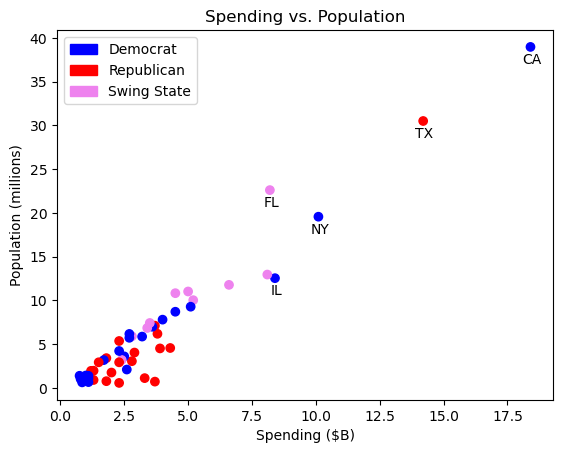

In [12]:
data = data.sort_values(by='spending', ascending=False, ignore_index=True)

color_map = {'dem':'blue', 'rep':'red', 'swing':'violet'}
colors = [color_map[party] for party in data.party_alt]

fig, ax = plt.subplots()

ax.scatter(data.spending, data.pop2023 / 10**6, color=colors)
ax.set_xlabel('Spending ($B)')
ax.set_ylabel('Population (millions)')
ax.set_title('Spending vs. Population')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(data[:5].area_abbr):
    plt.annotate(
        label, (data.spending[i], data.pop2023[i] / 10**6),
        textcoords="offset points", xytext=(1,-12), ha='center', 
    )

plt.show()

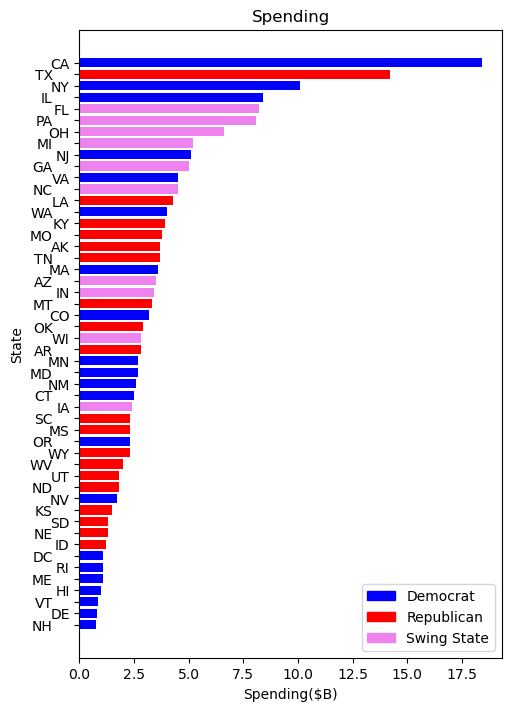

In [13]:
data = data.sort_values(by='spending', ascending=True, ignore_index=True)
colors = [color_map[party] for party in data.party_alt]

fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
ax.barh(data.area_abbr, data.spending, color=colors)
ax.set_title('Spending')
ax.set_xlabel('Spending($B)')
ax.set_ylabel('State')

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.04, 0))

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

plt.show()

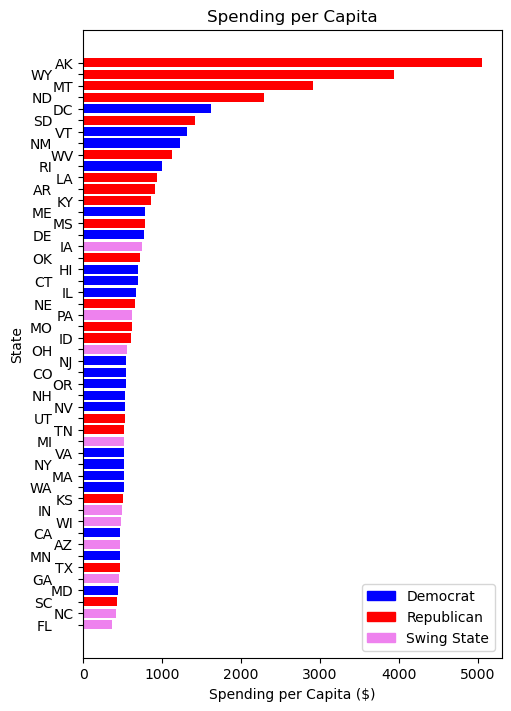

In [14]:
data = data.sort_values(by = 'spending_per_capita')

fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
for i in range(len(data)):
    row = data.iloc[i]
    bar = ax.barh(
        row['area_abbr'], row['spending_per_capita'], 
        color = color_map[row['party_alt']],
    )
ax.set_title('Spending per Capita')
ax.set_xlabel('Spending per Capita ($)')
ax.set_ylabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.05, 0))

plt.show()

In [15]:
denominators = {
    'pop2023':'Spending per Capita',
    'real_gdp':'Spending per Dollar of Real GDP',
    'debt':'Spending per Dollar of State Debt',
    'infrastructure':'Spending per Dollar of Annual Infrastructure Spending',
    'road_miles':'Spending per Mile of Road',
    'land_area':'Spending per Square Mile of Land Area',
}

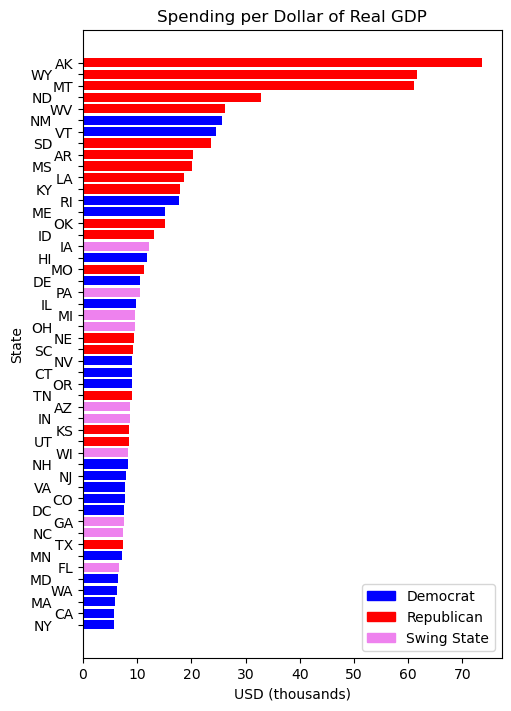

In [16]:
denominator = 'real_gdp'

data['new_col'] = data['spending'] * 10**9 / data[denominator] / 1000
data = data.sort_values(by='new_col')
color_map = {'dem':'blue', 'rep':'red', 'swing':'violet'}

fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
for i in range(len(data)):
    row = data.iloc[i]
    bar = ax.barh(
        row['area_abbr'], row['new_col'], 
        color = color_map[row['party_alt']],
    )
ax.set_title(denominators[denominator])
ax.set_xlabel('USD (thousands)')
ax.set_ylabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.05, 0))

data.drop('new_col', axis = 1, inplace = True)

plt.show()

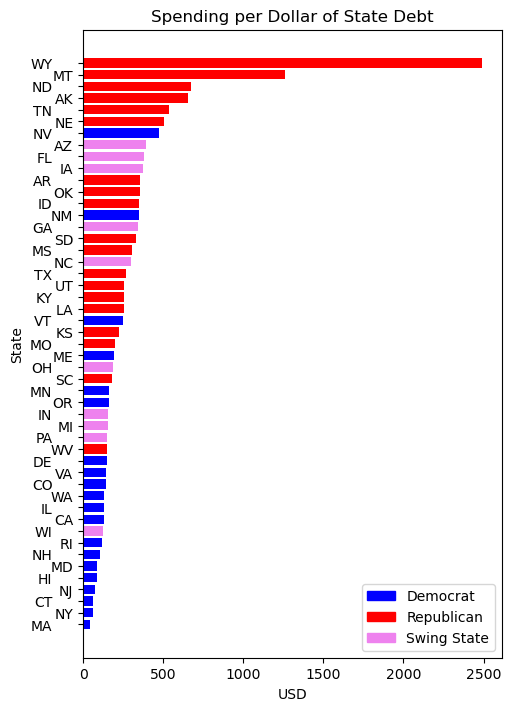

In [17]:
denominator = 'debt'

data_no_zero = data.loc[data[denominator] != 0, :].copy()

data_no_zero['new_col'] = data_no_zero['spending'] * 10**9 / data_no_zero[denominator]
data_no_zero = data_no_zero.sort_values(by='new_col')
color_map = {'dem':'blue', 'rep':'red', 'swing':'violet'}

fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
for i in range(len(data_no_zero)):
    row = data_no_zero.iloc[i]
    bar = ax.barh(
        row['area_abbr'], row['new_col'], 
        color = color_map[row['party_alt']],
    )
ax.set_title(denominators[denominator])
ax.set_xlabel('USD')
ax.set_ylabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.05, 0))

data_no_zero.drop('new_col', axis = 1, inplace = True)

plt.show()

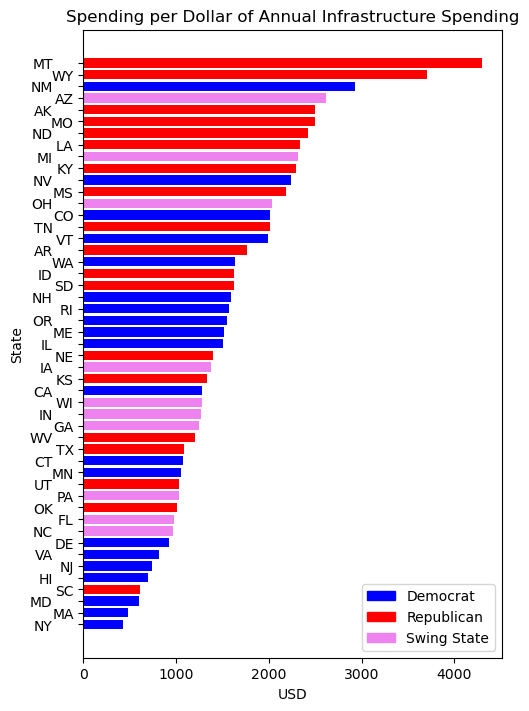

In [18]:
denominator = 'infrastructure'

data_no_zero = data.loc[data[denominator] != 0, :].copy()

data_no_zero['new_col'] = data_no_zero['spending'] * 10**9 / data_no_zero[denominator]
data_no_zero = data_no_zero.sort_values(by='new_col')
color_map = {'dem':'blue', 'rep':'red', 'swing':'violet'}

fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))
for i in range(len(data_no_zero)):
    row = data_no_zero.iloc[i]
    bar = ax.barh(
        row['area_abbr'], row['new_col'], 
        color = color_map[row['party_alt']],
    )
ax.set_title(denominators[denominator])
ax.set_xlabel('USD')
ax.set_ylabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0: 
        label.set_position((-0.05, 0))

data_no_zero.drop('new_col', axis = 1, inplace = True)

plt.show()

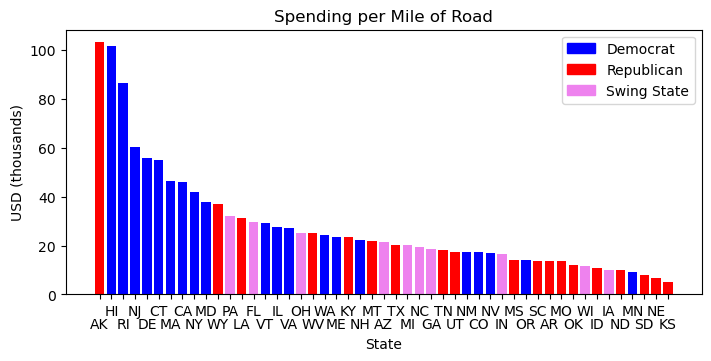

In [19]:
denominator = 'road_miles'

data_no_zero = data.loc[data.area_abbr != 'DC', :].copy()

data_no_zero['new_col'] = data_no_zero['spending'] * 10**9 / data_no_zero[denominator] / 1000
data_no_zero = data_no_zero.sort_values(by='new_col', ascending=False)
color_map = {'dem':'blue', 'rep':'red', 'swing':'violet'}

fig, ax = plt.subplots(layout='constrained', figsize=(7, 3.5))
for i in range(len(data_no_zero)):
    row = data_no_zero.iloc[i]
    bar = ax.bar(
        row['area_abbr'], row['new_col'], 
        color = color_map[row['party_alt']],
    )
ax.set_title(denominators[denominator])
ax.set_ylabel('USD (thousands)')
ax.set_xlabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 == 0: 
        label.set_position((0, -0.05))

data_no_zero.drop('new_col', axis = 1, inplace = True)

plt.show()

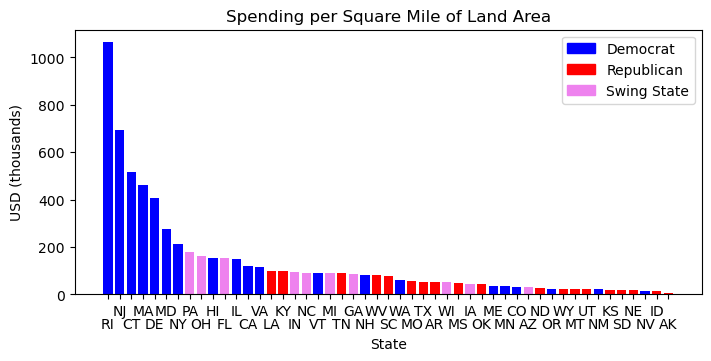

In [20]:
denominator = 'land_area'

data_no_zero = data.loc[data.area_abbr != 'DC', :].copy()

data_no_zero['new_col'] = data_no_zero['spending'] * 10**9 / data_no_zero[denominator] / 1000
data_no_zero = data_no_zero.sort_values(by='new_col', ascending=False)
color_map = {'dem':'blue', 'rep':'red', 'swing':'violet'}

fig, ax = plt.subplots(layout='constrained', figsize=(7, 3.5))
for i in range(len(data_no_zero)):
    row = data_no_zero.iloc[i]
    bar = ax.bar(
        row['area_abbr'], row['new_col'], 
        color = color_map[row['party_alt']],
    )
ax.set_title(denominators[denominator])
ax.set_ylabel('USD (thousands)')
ax.set_xlabel('State')

blue_patch = mpatches.Patch(color = 'blue', label = 'Democrat')
red_patch = mpatches.Patch(color = 'red', label = 'Republican')
purple_patch = mpatches.Patch(color = 'violet', label = 'Swing State')
ax.legend(handles = [blue_patch, red_patch, purple_patch])

for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 == 0: 
        label.set_position((0, -0.05))

data_no_zero.drop('new_col', axis = 1, inplace = True)

plt.show()